# Predicting the outcome of loan applications
# 1. Exploratory Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
from shared.plotting import percentage_stacked_bar_plot


## Load data
We have only 1000 data points.

In [2]:
df = pd.read_csv('./data/loan_data.csv')

In [3]:
len(df)

1000

In [4]:
df.head()

,checking_status,duration,loan_history,purpose,loan_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_loans,job,num_dependents,own_telephone,foreign_worker,accepted
0,<0DM,6,Critical_acct_other_loans_existing,radio/television,1169,Unknown_or_no_savings_acct,>7yrs,4,male_single,None,...,real_estate,67,none,own,m22,skilled_employee/official,1,Yes,yes,2
1,0_to_200DM,48,Existing_loans_paid_till_now,radio/television,5951,<100DM,1_to_4yrs,2,female_divorced/separated/married,None,...,real_estate,22,none,own,e1,skilled_employee/official,1,No,yes,1
2,None,12,Critical_acct_other_loans_existing,education,2096,<100DM,4_to_7yrs,2,male_single,None,...,real_estate,49,none,own,1,unskilled_resident,2,No,yes,2
3,<0DM,42,Existing_loans_paid_till_now,furniture/equipment,7882,<100DM,4_to_7yrs,2,male_single,guarantor,...,building_society_savings_agreement/life_insurance,45,none,for_free,q1,skilled_employee/official,2,No,yes,2
4,<0DM,24,Delay_in_past,new_car,4870,<100DM,1_to_4yrs,3,male_single,None,...,unknown/no_property,53,none,for_free,p22,skilled_employee/official,2,No,yes,1


## Look for missing values
There aren't any.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
loan_history              1000 non-null object
purpose                   1000 non-null object
loan_amount               1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
other_payment_plans       1000 non-null object
housing                   1000 non-null object
existing_loans            1000 non-null object
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
foreign

## Recode the label
I will re-encode the labels in a more intuitive way where `1` (positive) indicates something that requires human attention, i.e. a rejection, while `0` (negative) suggests that everything is fine, i.e. an acceptance.

In [6]:
df['label'] = df['accepted'].map({2: 0, 1: 1})

## Is the classification problem balanced?
We have more data about accepted applications than rejected applications, but there is no major imbalance. 

In [7]:
df['accepted'].value_counts()

2    700
1    300
Name: accepted, dtype: int64

## Distributions and correlations of the numerical features
There are only 3 numerical features. Their distributions do not reveal any outliers or particularly strong correlations, so it's probably a good idea to include all of them in a model. In the absence of any other information, the ranges look quite believable.

In [8]:
NUMERICAL_FEATURES = ['duration', 'loan_amount', 'age']

In [9]:
df[NUMERICAL_FEATURES].describe()

,duration,loan_amount,age
count,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000
std,12.058814,2822.736876,11.375469
min,4.000000,250.000000,19.000000
25%,12.000000,1365.500000,27.000000
50%,18.000000,2319.500000,33.000000
75%,24.000000,3972.250000,42.000000
max,72.000000,18424.000000,75.000000


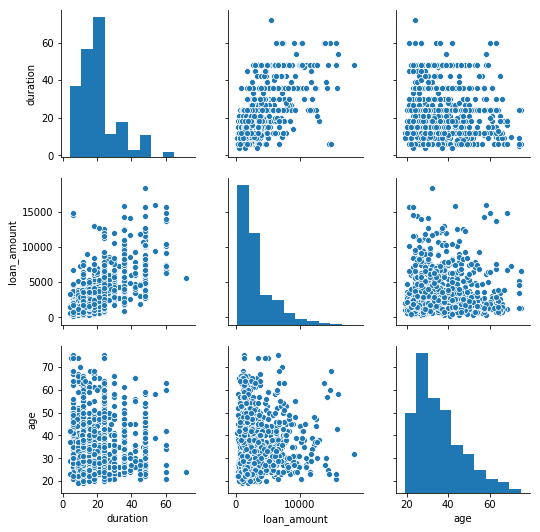

In [10]:
sns.pairplot(df[NUMERICAL_FEATURES])

## Analyse the effect of the numerical features on the outcome
Based on the plots below, we notice that all numerical features have some effect on the outcome.
- Rejected applications tend to be for longer periods of time.
- Rejected applications tend to be for higher amounts.
- Rejected applications tend to be from younger people

As such,  it's probably a good idea to use all the numerical features in the modelling.

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


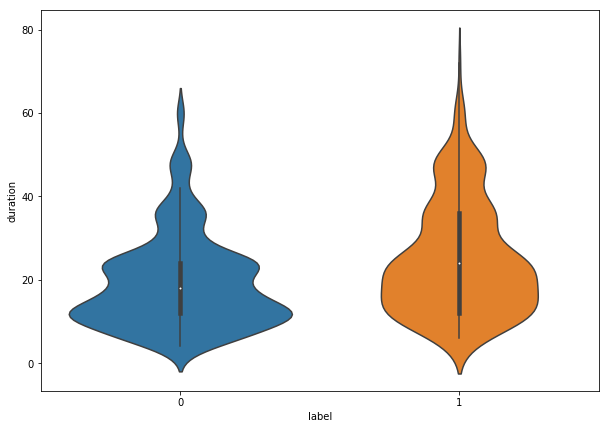

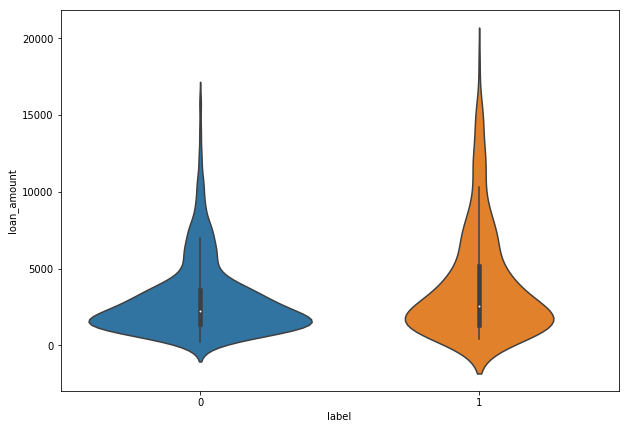

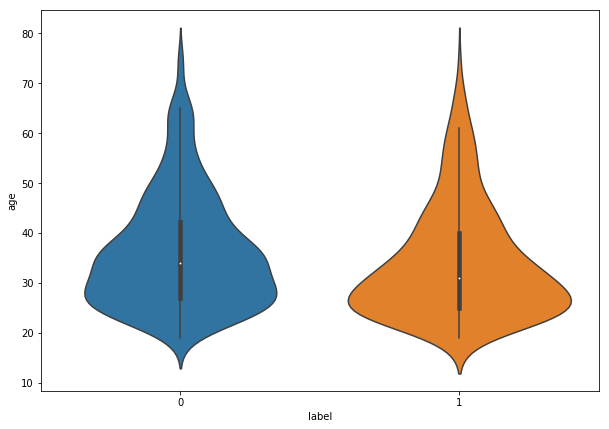

In [11]:
for f in NUMERICAL_FEATURES:
    plt.figure(figsize=(10,7))
    sns.violinplot(x='label', y=f, data=df)

## Analyse the effect of the categorical features on the outcome
How does the fraction of accepted application varies with the different levels of the categorical features? We will use percentage stacked bar plots to investigate that, and see if there is anything to be learned. In all plots below, **green** indicates accepted applications, **orange** indicates rejected applications the **black** dashed line shows the baseline fraction of 0.7 accepted applications in the whole data set.

We notice that the following features:
- `num_dependents`
- `own_telephone`
- `residence_since`

have litte or not effect on the outcome, so we will not use them in the modelling.

The following features:
- `installment_commitment`
- `personal_status`
- `job`

appear to have a weak effect, so we will try to use an automated way to select features to decide whether to keep them or not.

The others have a stronger effect, so  we will use them.

We notice that `loan_history` has a very counter-intuitive behaviour, where people with better history seem to be more likely to get rejected. Perhaps some mislabelling occured here.

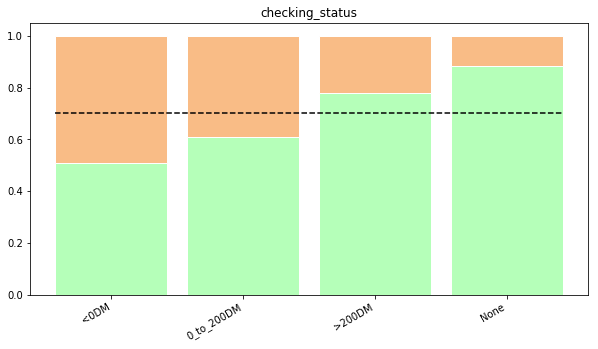

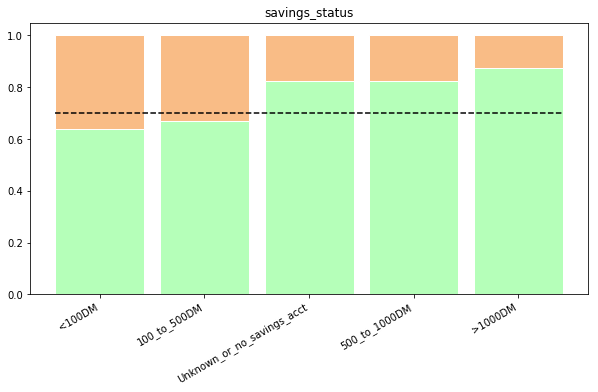

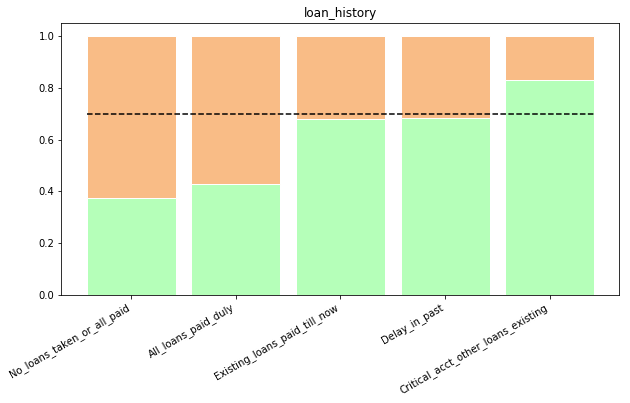

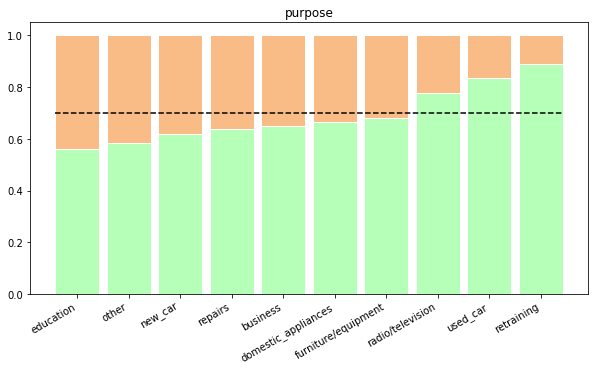

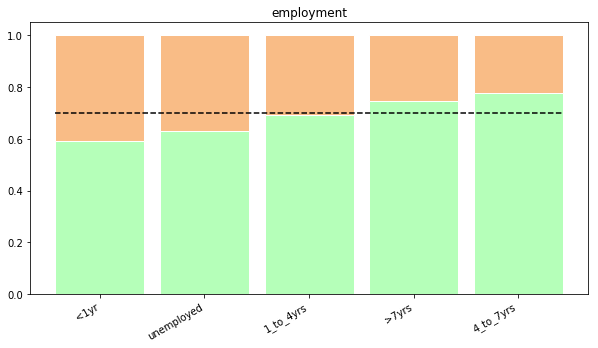

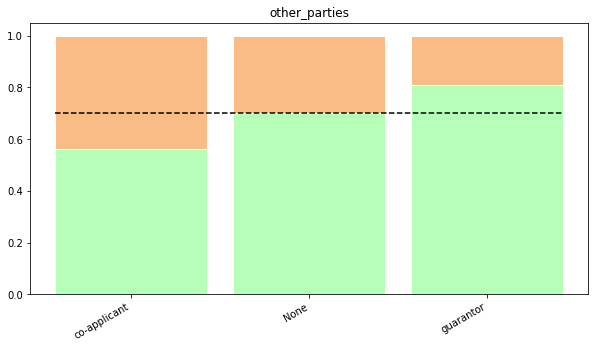

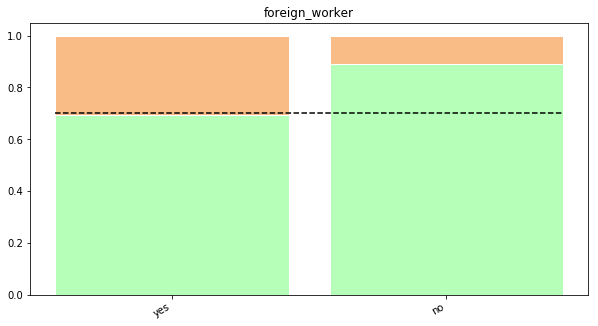

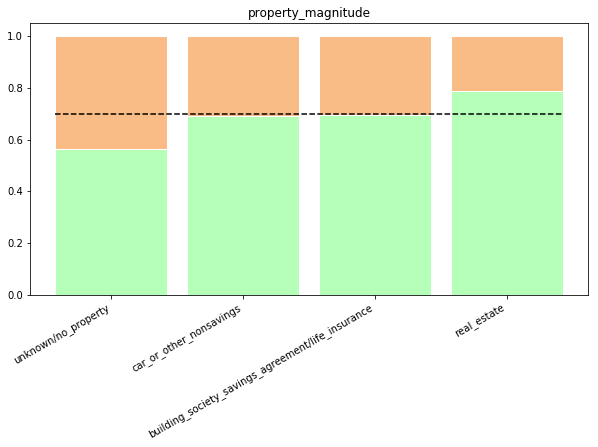

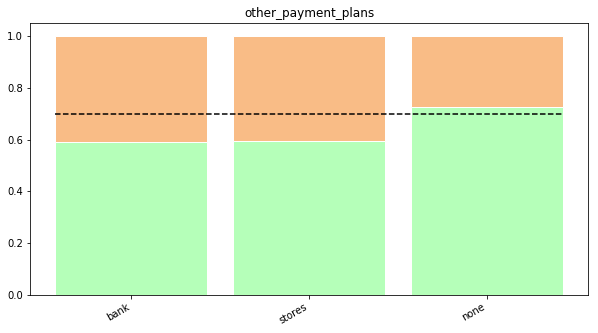

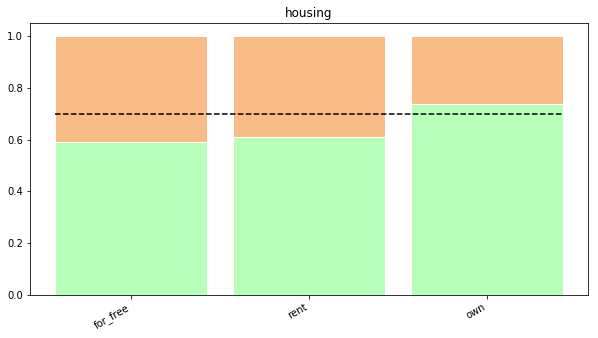

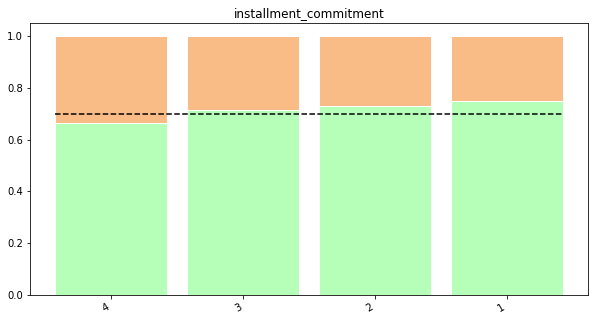

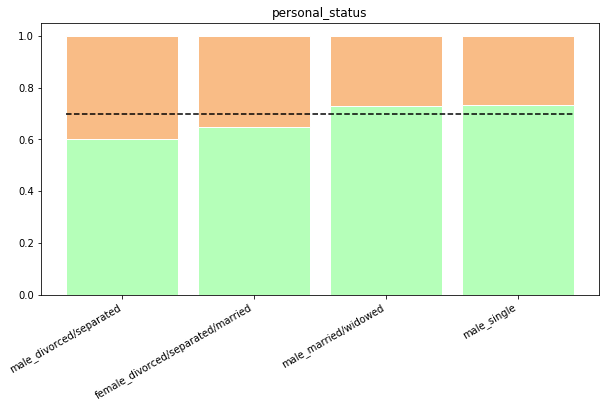

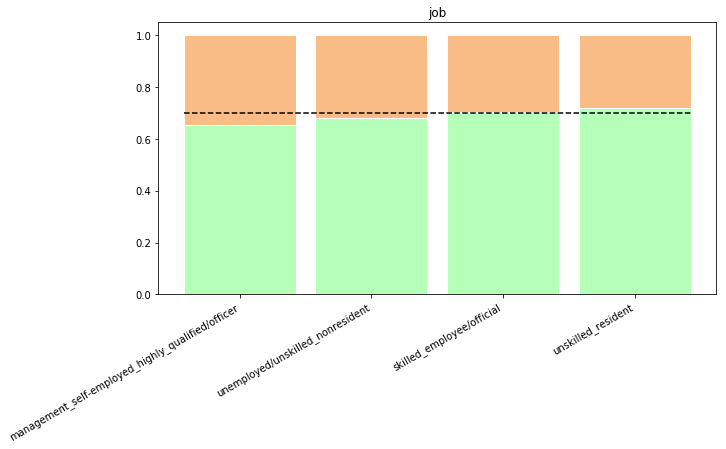

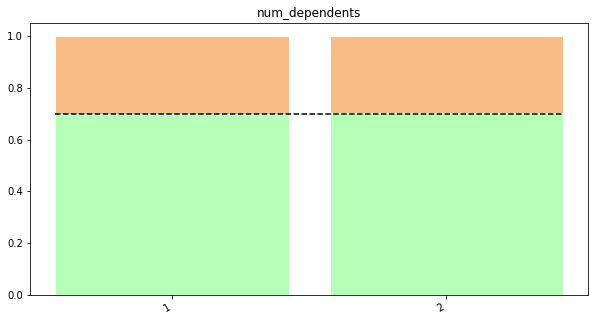

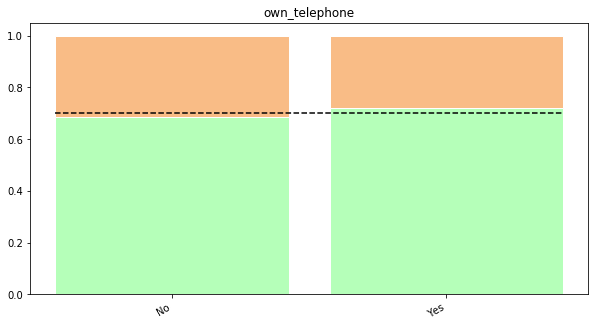

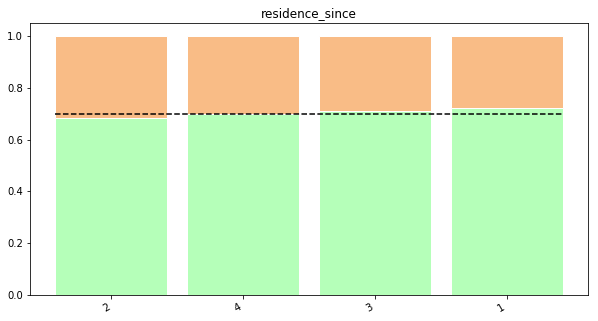

In [12]:
CATEGORICAL_FEATURES = ['checking_status', 'savings_status', 'loan_history', 'purpose', 'employment',
                        'other_parties', 'foreign_worker', 'property_magnitude', 'other_payment_plans', 'housing',
                        'installment_commitment', 'personal_status', 'job',
                        'num_dependents', 'own_telephone', 'residence_since']

for f in CATEGORICAL_FEATURES:
    percentage_stacked_bar_plot(f, 'label', df)

## The variable `existing_loans`
This one is a bit problematic, because it has a lot of different levels and from their codes it's not clear what they mean. Only two codes occur reasonably frequently, the others are very rare, and the vast majority occur only once of twice. The two codes that occur most frequently (which are `1` and `22`) show a very small effect on the fraction of positives. Based on this, I will not use this feature in the modelling.

In [13]:
el_levels = (
    df.groupby('existing_loans')
      .agg({
          'label': 'mean',
          'loan_amount': 'count'
      })
      .rename({
          'label': 'percent_positive',
          'loan_amount': 'num_examples'
      }, axis=1)
      .sort_values('num_examples', ascending=False)
)


In [14]:
el_levels.head(10)

,percent_positive,num_examples
existing_loans,,
1,0.296089,179
22,0.250000,100
z1,0.294118,17
f1,0.214286,14
e1,0.461538,13
n1,0.307692,13
i1,0.153846,13
s1,0.538462,13
w1,0.461538,13
